# ROUGE Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via ROUGE

In [141]:
%matplotlib inline

In [142]:
import pandas as pd
import numpy as np
import json
import glob
import gzip
import os

import scipy.stats

import matplotlib.pyplot as plt

In [143]:
import wikipedia

In [144]:
from torchmetrics.text.rouge import ROUGEScore

## Get CrisisFACTS Event Metadata

In [145]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [146]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire
https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [147]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [148]:
event_fact_lists = {}
event_fact_per_req = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    if not os.path.exists("../00-createSummaries/collapsed-event-days-new/Collapsed-%s.json" % req_id):
        print("CAUTION: No collapsed data for [%s]" % req_id)
        continue
    
    with open("../00-createSummaries/collapsed-event-days-new/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list
    
    event_fact_per_req.setdefault(event_id, {})[req_id] = ". ".join(local_fact_text).replace("..", ".")


In [149]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]
event_df["nist.summary.per.req"] = [event_fact_per_req.get(event_id, {}) for event_id in event_df.index]

## Save the Summaries

In [150]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries_perRequest.json")

In [151]:
# event_df = pd.read_json("CrisisFACTs-2022to2023.topics.withSummaries_smaller.json", lines=False)

In [152]:
rouge = ROUGEScore(
    use_stemmer=True,
    rouge_keys=("rouge2",)
)

In [153]:
TOP_K = 32

In [154]:
all_req_ids = list(annotation_data.keys())
all_req_ids

['CrisisFACTS-003-r5',
 'CrisisFACTS-003-r6',
 'CrisisFACTS-003-r7',
 'CrisisFACTS-003-r8',
 'CrisisFACTS-003-r9',
 'CrisisFACTS-003-r10',
 'CrisisFACTS-003-r11',
 'CrisisFACTS-004-r8',
 'CrisisFACTS-004-r9',
 'CrisisFACTS-004-r10',
 'CrisisFACTS-004-r11',
 'CrisisFACTS-004-r12',
 'CrisisFACTS-004-r13',
 'CrisisFACTS-004-r14',
 'CrisisFACTS-004-r15',
 'CrisisFACTS-004-r16',
 'CrisisFACTS-004-r17',
 'CrisisFACTS-004-r18',
 'CrisisFACTS-004-r19',
 'CrisisFACTS-004-r20',
 'CrisisFACTS-004-r21',
 'CrisisFACTS-004-r22',
 'CrisisFACTS-006-r4',
 'CrisisFACTS-006-r5',
 'CrisisFACTS-006-r6',
 'CrisisFACTS-006-r7',
 'CrisisFACTS-007-r13',
 'CrisisFACTS-007-r14',
 'CrisisFACTS-013-r0',
 'CrisisFACTS-013-r1',
 'CrisisFACTS-013-r2',
 'CrisisFACTS-013-r3',
 'CrisisFACTS-013-r4',
 'CrisisFACTS-013-r5',
 'CrisisFACTS-014-r0',
 'CrisisFACTS-014-r1',
 'CrisisFACTS-014-r2',
 'CrisisFACTS-014-r3',
 'CrisisFACTS-014-r4',
 'CrisisFACTS-014-r5',
 'CrisisFACTS-014-r6',
 'CrisisFACTS-001-r3',
 'CrisisFACTS-001

In [155]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("\\")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        
    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]
        if len(this_submitted_summary) == 0:
            continue

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")
        
        nist_summary = event["nist.summary"]
        wiki_summary = event["wiki.summary"]

        print(f"Event {event_id} -- NIST: {len(nist_summary)} -- Submitted: {len(this_summary_text)}")

        nist_metric_ = rouge(this_summary_text, nist_summary)
        wiki_metric_ = rouge(this_summary_text, wiki_summary)
        
        nist_metric = {
            "f1": nist_metric_["rouge2_fmeasure"],
            "precision": nist_metric_["rouge2_precision"],
            "recall": nist_metric_["rouge2_recall"],
        }
        
        wiki_metric = {
            "f1": wiki_metric_["rouge2_fmeasure"],
            "precision": wiki_metric_["rouge2_precision"],
            "recall": wiki_metric_["rouge2_recall"],
        }
        
        this_wiki_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in nist_metric.items()])

        display(this_nist_df)
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric")["value"].mean())



submissions\Thesis_Retriver.gz --> Thesis_Retriver
Event CrisisFACTS-001 -- NIST: 9999 -- Submitted: 83129


,metric,value,event
0,f1,0.212369,CrisisFACTS-001
1,precision,0.118987,CrisisFACTS-001
2,recall,0.986908,CrisisFACTS-001


Event CrisisFACTS-002 -- NIST: 9588 -- Submitted: 51633


,metric,value,event
0,f1,0.312126,CrisisFACTS-002
1,precision,0.185413,CrisisFACTS-002
2,recall,0.985897,CrisisFACTS-002


Event CrisisFACTS-003 -- NIST: 22809 -- Submitted: 53415


,metric,value,event
0,f1,0.588427,CrisisFACTS-003
1,precision,0.419332,CrisisFACTS-003
2,recall,0.986050,CrisisFACTS-003


Event CrisisFACTS-004 -- NIST: 29148 -- Submitted: 144427


,metric,value,event
0,f1,0.321732,CrisisFACTS-004
1,precision,0.193224,CrisisFACTS-004
2,recall,0.960609,CrisisFACTS-004


Event CrisisFACTS-005 -- NIST: 10447 -- Submitted: 45438


,metric,value,event
0,f1,0.373076,CrisisFACTS-005
1,precision,0.229917,CrisisFACTS-005
2,recall,0.988684,CrisisFACTS-005


Event CrisisFACTS-006 -- NIST: 12315 -- Submitted: 34894


,metric,value,event
0,f1,0.298348,CrisisFACTS-006
1,precision,0.203267,CrisisFACTS-006
2,recall,0.560561,CrisisFACTS-006


Event CrisisFACTS-007 -- NIST: 10726 -- Submitted: 26602


,metric,value,event
0,f1,0.566396,CrisisFACTS-007
1,precision,0.397244,CrisisFACTS-007
2,recall,0.986431,CrisisFACTS-007


Event CrisisFACTS-008 -- NIST: 24872 -- Submitted: 77658


,metric,value,event
0,f1,0.469790,CrisisFACTS-008
1,precision,0.310206,CrisisFACTS-008
2,recall,0.967539,CrisisFACTS-008


Event CrisisFACTS-009 -- NIST: 4690 -- Submitted: 72980


,metric,value,event
0,f1,0.117817,CrisisFACTS-009
1,precision,0.062634,CrisisFACTS-009
2,recall,0.990528,CrisisFACTS-009


Event CrisisFACTS-010 -- NIST: 2154 -- Submitted: 38310


,metric,value,event
0,f1,0.106750,CrisisFACTS-010
1,precision,0.056403,CrisisFACTS-010
2,recall,0.994152,CrisisFACTS-010


Event CrisisFACTS-011 -- NIST: 1532 -- Submitted: 26752


,metric,value,event
0,f1,0.103290,CrisisFACTS-011
1,precision,0.054520,CrisisFACTS-011
2,recall,0.979339,CrisisFACTS-011


Event CrisisFACTS-012 -- NIST: 7206 -- Submitted: 38297


,metric,value,event
0,f1,0.310571,CrisisFACTS-012
1,precision,0.184240,CrisisFACTS-012
2,recall,0.988095,CrisisFACTS-012


Event CrisisFACTS-013 -- NIST: 12409 -- Submitted: 40408


,metric,value,event
0,f1,0.444232,CrisisFACTS-013
1,precision,0.290484,CrisisFACTS-013
2,recall,0.943740,CrisisFACTS-013


Event CrisisFACTS-014 -- NIST: 12252 -- Submitted: 88700


,metric,value,event
0,f1,0.240895,CrisisFACTS-014
1,precision,0.137136,CrisisFACTS-014
2,recall,0.989733,CrisisFACTS-014


Event CrisisFACTS-015 -- NIST: 8922 -- Submitted: 80034


,metric,value,event
0,f1,0.185095,CrisisFACTS-015
1,precision,0.103057,CrisisFACTS-015
2,recall,0.907534,CrisisFACTS-015


Event CrisisFACTS-016 -- NIST: 5943 -- Submitted: 31883


,metric,value,event
0,f1,0.302918,CrisisFACTS-016
1,precision,0.179773,CrisisFACTS-016
2,recall,0.961661,CrisisFACTS-016


Event CrisisFACTS-017 -- NIST: 8773 -- Submitted: 50915


,metric,value,event
0,f1,0.286367,CrisisFACTS-017
1,precision,0.167518,CrisisFACTS-017
2,recall,0.985694,CrisisFACTS-017


Event CrisisFACTS-018 -- NIST: 23672 -- Submitted: 41956


,metric,value,event
0,f1,0.467742,CrisisFACTS-018
1,precision,0.365957,CrisisFACTS-018
2,recall,0.647960,CrisisFACTS-018


metric
f1           0.317108
precision    0.203295
recall       0.933951
Name: value, dtype: float64

In [156]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.rouge/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.rouge/all_runs.csv", index=False)

Thesis_Retriver


In [157]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        # this_row = group.pivot("event", "metric", "value").mean()
        this_row = group.pivot(index="event", columns="metric", values="value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.rouge/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

Thesis_Retriver
Thesis_Retriver


In [158]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [159]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

Thesis_Retriver
	 nist
		 f1 0.25656784474849703
		 precision 0.1601722028106451
		 recall 0.9388437330722809
	 wiki
		 f1 0.0202999907778576
		 precision 0.010481141856871545
		 recall 0.398652583360672


In [160]:
by_run_df = pd.DataFrame(rows)#.set_index("run")
by_run_df.to_csv("by_run.rouge.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
0,0.256568,0.0203


In [161]:
# correlation between wiki and nist
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,NaN,NaN
wiki.f1,NaN,NaN


<Axes: xlabel='nist.f1', ylabel='wiki.f1'>

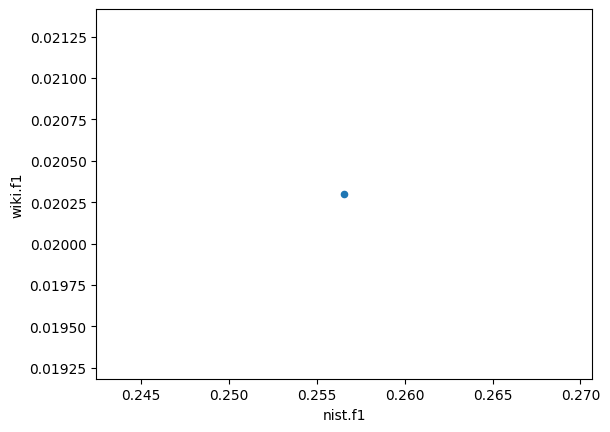

In [162]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

<Axes: >

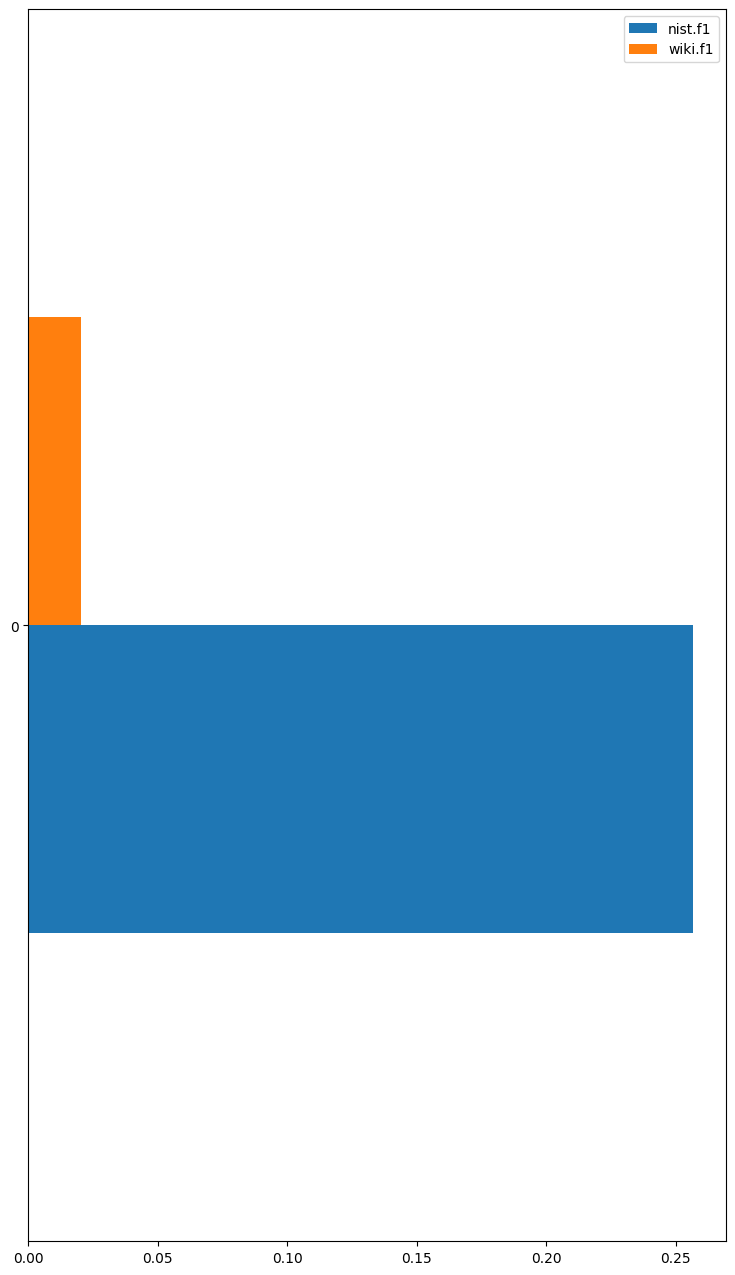

In [163]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

In [164]:
by_run_df

,run,nist.f1,nist.precision,nist.recall,wiki.f1,wiki.precision,wiki.recall
0,Thesis_Retriver,0.256568,0.160172,0.938844,0.0203,0.010481,0.398653


## By Day

In [165]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-009
	 nist
		 f1 0.1178174763917923
		 precision 0.0626336932182312
		 recall 0.9905277490615845
	 wiki
		 f1 0.020141489803791046
		 precision 0.010353384539484978
		 recall 0.36890244483947754
CrisisFACTS-010
	 nist
		 f1 0.10675039142370224
		 precision 0.056403450667858124
		 recall 0.9941520690917969
	 wiki
		 f1 0.024703240022063255
		 precision 0.012773722410202026
		 recall 0.37378641963005066
CrisisFACTS-011
	 nist
		 f1 0.10329047590494156
		 precision 0.05452035740017891
		 recall 0.9793388247489929
	 wiki
CrisisFACTS-012
	 nist
		 f1 0.310570627450943
		 precision 0.1842397302389145
		 recall 0.988095223903656
	 wiki
CrisisFACTS-013
	 nist
		 f1 0.44423237442970276
		 precision 0.29048362374305725
		 recall 0.9437404870986938
	 wiki
		 f1 0.01435552816838026
		 precision 0.007332293316721916
		 recall 0.34057971835136414
CrisisFACTS-014
	 nist
		 f1 0.240894615650177
		 precision 0.13713635504245758
		 recall 0.9897330403327942
	 wiki
		 f1 0.036497343331575394


In [166]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.rouge.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-009,0.117817,0.020141
CrisisFACTS-010,0.106750,0.024703
CrisisFACTS-011,0.103290,NaN
CrisisFACTS-012,0.310571,NaN
CrisisFACTS-013,0.444232,0.014356
CrisisFACTS-014,0.240895,0.036497
CrisisFACTS-015,0.185095,0.010464
CrisisFACTS-016,0.302918,0.026925
CrisisFACTS-017,0.286367,0.013189


<Axes: ylabel='event'>

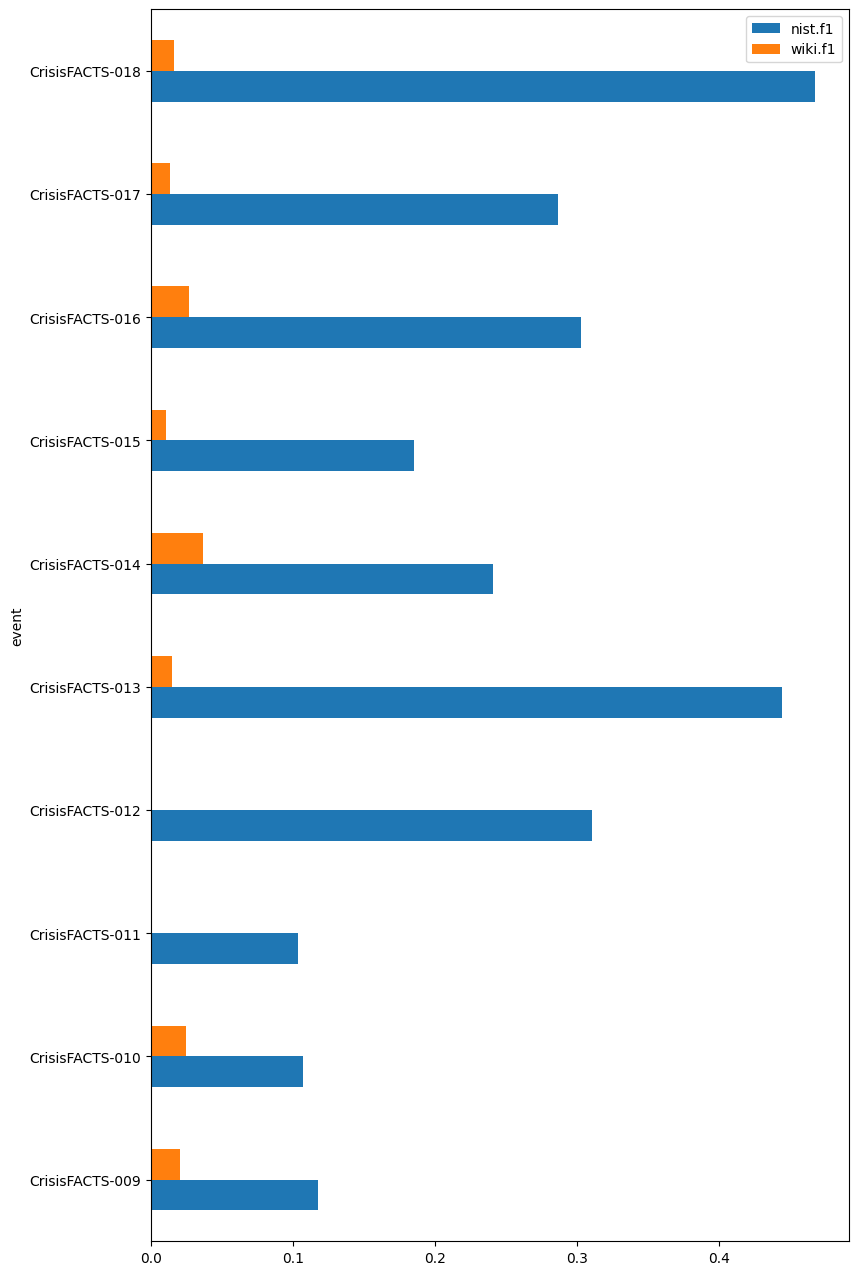

In [167]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [168]:
score_df = pd.read_csv("by_event.rouge.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-009 & 0.117817 & 0.062634 & 0.990528 & 0.020141 & 0.010353 & 0.368902 \\
CrisisFACTS-010 & 0.106750 & 0.056403 & 0.994152 & 0.024703 & 0.012774 & 0.373786 \\
CrisisFACTS-011 & 0.103290 & 0.054520 & 0.979339 & nan & nan & nan \\
CrisisFACTS-012 & 0.310571 & 0.184240 & 0.988095 & nan & nan & nan \\
CrisisFACTS-013 & 0.444232 & 0.290484 & 0.943740 & 0.014356 & 0.007332 & 0.340580 \\
CrisisFACTS-014 & 0.240895 & 0.137136 & 0.989733 & 0.036497 & 0.019063 & 0.427432 \\
CrisisFACTS-015 & 0.185095 & 0.103057 & 0.907534 & 0.010464 & 0.005289 & 0.485714 \\
CrisisFACTS-016 & 0.302918 & 0.179773 & 0.961661 & 0.026925 & 0.014135 & 0.282869 \\
CrisisFACTS-017 & 0.286367 & 0.167518 & 0.985694 & 0.013189 & 0.006686 & 0.482456 \\
CrisisFACTS-018 & 0.467742 & 0.365957 & 0.647960 & 0.016124 & 0.008217 & 0.427481 \\
\end{tabular}

